# 設定ファイル読み込み

In [1]:
from src.utils.config import load_config
config = load_config('config','config', overrides=['trainer.max_epochs=10'])

ModuleNotFoundError: No module named 'src'

In [2]:
from omegaconf import OmegaConf
OmegaConf.to_container(config, resolve=True)

{'model': {'name': 'AutoEncoder',
  'instance': {'_target_': 'src.models.AutoEncoder.model.AutoEncoder'},
  'optimizer': {'_target_': 'torch.optim.Adam', 'lr': 1e-05},
  'net': {'hidden_size': [16, 8, 4],
   'z_dim': 4,
   'dropout': 0,
   'batch_size': 32},
  'data': {'window_size': 1,
   'feature_cols': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
   'input_vec': 'features'}},
 'data': {'name': 'EEG',
  'dataset_class': 'TSDataset',
  'target_type': 'generative',
  'input_vec': 'features',
  'num_workers': 0,
  'file_type': 'file',
  'feature_cols': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  'window_size': 1,
  'train': {'batch_size': 32,
   'slide_step': 1,
   'file': 'EEG Eye State.arff',
   'split_size': 0.7},
  'val': {'batch_size': 32,
   'slide_step': 1,
   'file': 'EEG Eye State.arff',
   'split_size': 0.3},
  'test': {'batch_size': 1, 'slide_step': 1, 'file': 'EEG Eye State.arff'}},
 'logger': {'_target_': 'pytorch_lightning.loggers.MLFlowLogger',
  'experiment_name

# データファイル読み込み

In [3]:
from src.utils.dataset import DataModule
dm = DataModule(config.data)

In [4]:
dm.setup()

train  (x,y):  (4706, 1, 14) (4706, 1, 14)
train total: (x,y):  (4706, 1, 14) (4706, 1, 14)
val  (x,y):  (2017, 1, 14) (2017, 1, 14)
val total: (x,y):  (2017, 1, 14) (2017, 1, 14)
test  (x,y):  (14980, 1, 14) (14980, 1, 14)
test total: (x,y):  (14980, 1, 14) (14980, 1, 14)


# AnomalyDetector の定義・訓練

## 定義

optuna の保存フォルダを指定した場合に、フォルダを自動作成してくれないので、自分で準備すること

In [5]:
from src import AnomalyDetector
if 'ad' in locals(): 
    del ad
ad = AnomalyDetector(config)

AutoEncoder(
  (encoder): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=14, out_features=16, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=16, out_features=8, bias=True)
      (4): ReLU()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=8, out_features=4, bias=True)
      (7): ReLU()
      (8): Dropout(p=0, inplace=False)
    )
    (z): Linear(in_features=4, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (hidden): ModuleList(
      (0): Linear(in_features=4, out_features=4, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=4, out_features=8, bias=True)
      (4): ReLU()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=8, out_features=16, bias=True)
      (7): ReLU()
      (8): Dropout(p=0, inplace=False)
    )
    (output): Linear(in_features=16, out_features=14, bias=True)
  )
)


## パラメータ探索(初回)

In [6]:
ad.train(dm=dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name             | Type       | Params
-------------------------------------------------
0  | encoder          | Encoder    | 432   
1  | encoder.hidden   | ModuleList | 412   
2  | encoder.hidden.0 | Linear     | 240   
3  | encoder.hidden.1 | ReLU       | 0     
4  | encoder.hidden.2 | Dropout    | 0     
5  | encoder.hidden.3 | Linear     | 136   
6  | encoder.hidden.4 | ReLU       | 0     
7  | encoder.hidden.5 | Dropout    | 0     
8  | encoder.hidden.6 | Linear     | 36    
9  | encoder.hidden.7 | ReLU       | 0     
10 | encoder.hidden.8 | Dropout    | 0     
11 | encoder.z        | Linear     | 20    
12 | decoder          | Decoder    | 442   
13 | decoder.hidden   | ModuleList | 204   
14 | decoder.hidden.0 | Linear     | 20    
15 | decoder.hidden.1 | ReLU       | 0     
16 | decoder.hidden.2 | Dropout    | 0     
17 | decoder.hidden.3 | Linear     | 40    

Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Saving latest checkpoint...


## 上の処理から継続して行う(MLFlowの同じ実験に継続してデータを保存する)場合

In [11]:
ad.train_from(n_epoch='last', max_epochs=50, logger=ad.logger, dm=dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name             | Type       | Params
-------------------------------------------------
0  | encoder          | Encoder    | 432   
1  | encoder.hidden   | ModuleList | 412   
2  | encoder.hidden.0 | Linear     | 240   
3  | encoder.hidden.1 | ReLU       | 0     
4  | encoder.hidden.2 | Dropout    | 0     
5  | encoder.hidden.3 | Linear     | 136   
6  | encoder.hidden.4 | ReLU       | 0     
7  | encoder.hidden.5 | Dropout    | 0     
8  | encoder.hidden.6 | Linear     | 36    
9  | encoder.hidden.7 | ReLU       | 0     
10 | encoder.hidden.8 | Dropout    | 0     
11 | encoder.z        | Linear     | 20    
12 | decoder          | Decoder    | 442   
13 | decoder.hidden   | ModuleList | 204   
14 | decoder.hidden.0 | Linear     | 20    
15 | decoder.hidden.1 | ReLU       | 0     
16 | decoder.hidden.2 | Dropout    | 0     
17 | decoder.hidden.3 | Linear     | 40    

Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Saving latest checkpoint...


## 訓練済みモデルからの実行

In [11]:
ad.train_from(n_epoch=49, max_epochs=200, save_dir='./mlruns', experiment_id = '0', run_id = 'c6a4971015dc4c5c9c80112ae7b7ab87', dm=dm)
#ad.train_from(n_epoch=156, max_epochs=200, save_dir='./mlruns', experiment_id = '0', run_id = '2139cc6392cc4a109c13f7a4b345445a', dm=dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name             | Type       | Params
-------------------------------------------------
0  | encoder          | Encoder    | 432   
1  | encoder.hidden   | ModuleList | 412   
2  | encoder.hidden.0 | Linear     | 240   
3  | encoder.hidden.1 | ReLU       | 0     
4  | encoder.hidden.2 | Dropout    | 0     
5  | encoder.hidden.3 | Linear     | 136   
6  | encoder.hidden.4 | ReLU       | 0     
7  | encoder.hidden.5 | Dropout    | 0     
8  | encoder.hidden.6 | Linear     | 36    
9  | encoder.hidden.7 | ReLU       | 0     
10 | encoder.hidden.8 | Dropout    | 0     
11 | encoder.z        | Linear     | 20    
12 | decoder          | Decoder    | 442   
13 | decoder.hidden   | ModuleList | 204   
14 | decoder.hidden.0 | Linear     | 20    
15 | decoder.hidden.1 | ReLU       | 0     
16 | decoder.hidden.2 | Dropout    | 0     
17 | decoder.hidden.3 | Linear     | 40    

Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Saving latest checkpoint...


# 評価

In [12]:
ad.model_checkpoint.best_model_path

'C:\\Users\\k_shinoda\\Program\\PytorchLightning_Hydara_MLFlow_Optuna\\mlruns\\0\\c6a4971015dc4c5c9c80112ae7b7ab87\\artifacts\\models\\model-epoch=49.ckpt'

In [13]:
ad.trainer.resume_from_checkpoint

'C:\\Users\\k_shinoda\\Program\\PytorchLightning_Hydara_MLFlow_Optuna\\mlruns\\0\\c6a4971015dc4c5c9c80112ae7b7ab87\\artifacts\\models\\model-epoch=9.ckpt'

## 既存モデルの読み込み

In [6]:
ad.load_ckpt(n_epoch=49, save_dir='mlruns', experiment_id = '0', run_id = 'c6a4971015dc4c5c9c80112ae7b7ab87')

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


## test 実行
pytorch-lightning 1.1.2 はで load_ckpt から test を実行しても想定される test_loss となるが、1.1.3 以降だと、model

In [7]:
ad.test(dm=dm)

Testing: |                                                                                       | 0/? [00:00<…

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2401256263256073}
--------------------------------------------------------------------------------


In [8]:
anomaly_scores = ad.get_anomaly_scores(dm=dm)

In [9]:
import pandas as pd
df = pd.DataFrame(anomaly_scores)

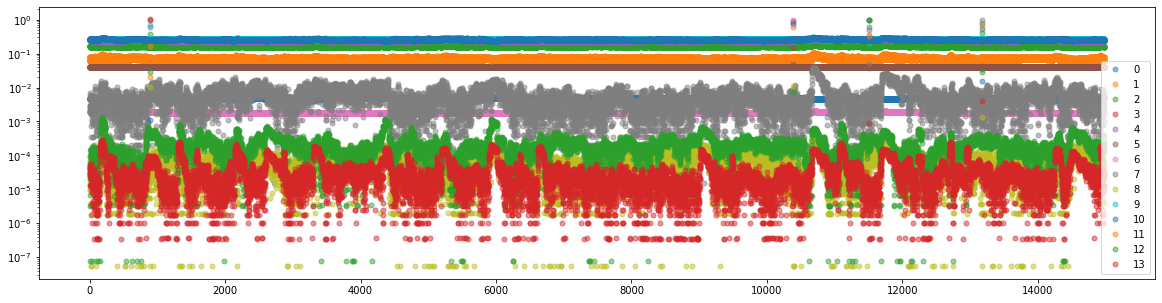

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
df.plot.line(ax=ax, style='o',ms=5, alpha=.5)
ax.semilogy()
#df.rolling(50, center=True).mean().plot.line(ax=ax, style='g--', alpha=.5)
#ax2 = ax.twinx()
#pd.read_csv('./data/dsc_2019/predict/data01_predict.csv').plot(ax=ax2,style='--', alpha=.3, label='observe')
#fig.savefig('tmp.svg')
plt.show()

In [11]:
from scipy.io import arff
import pandas as pd
label, _ = arff.loadarff('data/EEG/EEG Eye State.arff')
label = pd.DataFrame(label).values

In [12]:
label = label[:,[-1]]
label = label.astype(int)

In [13]:
len(label)

14980

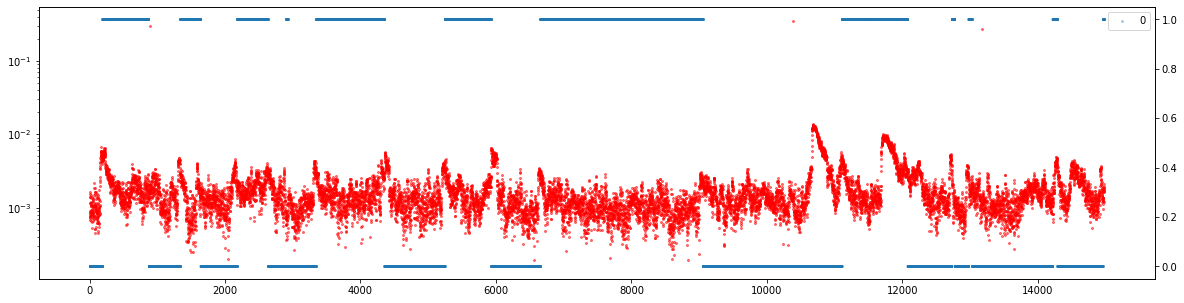

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
df.mean(axis=1).plot.line(ax=ax, style='ro',ms=2, alpha=.5)
#df.rolling(50, center=True).mean().plot.line(ax=ax, style='g--', alpha=.5)
ax.semilogy()
ax2 = ax.twinx()
pd.DataFrame(label).plot(ax=ax2, style='o', ms=2, alpha=.3, label='observe')
#fig.savefig('tmp.svg')
plt.show()

eysState==b'1'(== eye close)をtrain/valデータとして使って使っているんだけど、脳波だと目をつむっていても関係ない刺激があるということなのかな。先に特徴エンジニアリングが必要な感じかぁ...